In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

### Data Exploration and Understanding

In [2]:
# Loading in the dataset
df = pd.read_csv("brca_data_w_subtypes.csv")
print(df.info())
print()
print(df.head())
print()
print(df.describe())
print()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB
None

   rs_CLEC3A    rs_CPB1  rs_SCGB2A2  rs_SCGB1D2    rs_TFF1   rs_MUCL1  \
0   0.892818   6.580103   14.123672   10.606501  13.189237   6.649466   
1   0.000000   3.691311   17.116090   15.517231   9.867616   9.691667   
2   3.748150   4.375255    9.658123    5.326983  12.109539  11.644307   
3   0.000000  18.235519   18.535480   14.533584  14.078992   8.913760   
4   0.000000   4.583724   15.711865   12.804521   8.881669   8.430028   

    rs_GSTM1     rs_PIP  rs_ADIPOQ   rs_ADH1B  ...  pp_p62.LCK.ligand  \
0  10.520335  10.338490  10.248379  10.229970  ...          -0.691766   
1   8.179522   7.911723   1.289598   1.818891  ...           0.279067   
2  10.517330   5.114925  11.975349  11.911437  ...           0.219910   
3  10.557465  13.304434   8.205059   9.211476  ...          -0.266554

### Getting specifics about the Multi-omics dataset and other correlations

In [3]:
print("Multi-omics variables in the dataset.")
print("Number of RNAseq expression variables:", len([match for match in df.columns if match.startswith("rs")]))
print("Number of Copy Number Variables:", len([match for match in df.columns if match.startswith("cn")]))
print("Number of Protein Levels Variables:", len([match for match in df.columns if match.startswith("pp")]))
print("Number of Somatic Mutations in data:", len([match for match in df.columns if match.startswith("mu")]))

print()
print("There are 5 outcomes for the omics data above")
print("Vital Status:", df["vital.status"].unique())
print("Progesterone Receptors: ", (df["PR.Status"]).unique())
print("Estrogen Receptors: ", (df["ER.Status"]).unique())
print("HER2 Status", (df["HER2.Final.Status"]).unique())
print("Histological Cancer Subtype", (df["histological.type"]).unique())

Multi-omics variables in the dataset.
Number of RNAseq expression variables: 604
Number of Copy Number Variables: 860
Number of Protein Levels Variables: 223
Number of Somatic Mutations in data: 249

There are 5 outcomes for the omics data above
Vital Status: [0 1]
Progesterone Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
Estrogen Receptors:  ['Positive' 'Negative' nan 'Performed but Not Available' 'Indeterminate'
 'Not Performed']
HER2 Status ['Negative' nan 'Positive' 'Equivocal' 'Not Available']
Histological Cancer Subtype ['infiltrating ductal carcinoma' 'infiltrating lobular carcinoma']


In [4]:
gene_suffix = ['rs_', 'cn_', 'mu_']
genes_all = []

for col in df.columns:
    for suffix in gene_suffix:
        if col.startswith(suffix):
            gene = col[len(suffix):]
            if all(suffix + gene in df.columns for suffix in gene_suffix):
                genes_all.append(gene)
unique_genes = set(genes_all)
print(unique_genes)

{'MYH11', 'FAT2', 'CNTNAP2', 'GPR98', 'MUC16', 'FOXA1', 'PEG3'}


### Analyzing data of a single gene and multiple genes multi-omics data to understand and predict effects on the outcomes

In [5]:
# Selecting genes here to analyze and use the first one for single gene omics analysis
df_muc16 = df[[val for val in df.columns if "MUC16" in val]]
print(df_muc16)


     rs_MUC16  cn_MUC16  mu_MUC16
0    2.715718         1         1
1    4.811800         0         0
2    6.842515        -1         0
3    4.535344        -1         0
4    4.676053         0         1
..        ...       ...       ...
700  2.054710         0         0
701  3.834195         0         0
702  3.323918         0         0
703  1.316783         0         0
704  7.617837         0         1

[705 rows x 3 columns]


In [6]:
omics_unique_genes = [col for col in df.columns if any(gene in col for gene in unique_genes)]
print(omics_unique_genes)

['rs_MUC16', 'rs_CNTNAP2', 'rs_GPR98', 'rs_FOXA1', 'rs_FAT2', 'rs_PEG3', 'rs_MYH11', 'cn_GPR98', 'cn_FAT2', 'cn_CNTNAP2', 'cn_FOXA1', 'cn_MYH11', 'cn_MUC16', 'cn_PEG3', 'mu_MUC16', 'mu_FAT2', 'mu_GPR98', 'mu_MYH11', 'mu_FOXA1', 'mu_CNTNAP2', 'mu_PEG3', 'pp_MYH11']


In [7]:
for gene_data in omics_unique_genes:
    print(f"T-Test on relationship between {gene_data} and patient survival")
    mean_alive = df.loc[df["vital.status"] == 0, gene_data].mean()
    mean_dead = df.loc[df["vital.status"] == 1, gene_data].mean()
    # print(f"Mean in Dead: {mean_dead}")
    # print(f"Mean in Alive: {mean_alive}")
    
    t_stat, p_val = ttest_ind(df.loc[df["vital.status"] == 0, gene_data],
                              df.loc[df["vital.status"] == 1, gene_data])
    
    print(f'T-statistic: {t_stat}')
    print(f'P-value: {p_val}')
    print(f"")

T-Test on relationship between rs_MUC16 and patient survival
T-statistic: -2.1354729424193644
P-value: 0.03306737441965191

T-Test on relationship between rs_CNTNAP2 and patient survival
T-statistic: 2.699933744804915
P-value: 0.0071021329740718715

T-Test on relationship between rs_GPR98 and patient survival
T-statistic: -1.7579877371890567
P-value: 0.07918474779417059

T-Test on relationship between rs_FOXA1 and patient survival
T-statistic: 0.8244993291490502
P-value: 0.4099355518391745

T-Test on relationship between rs_FAT2 and patient survival
T-statistic: -3.2309560776720154
P-value: 0.0012912649579201027

T-Test on relationship between rs_PEG3 and patient survival
T-statistic: -2.706877930325158
P-value: 0.006956801568734718

T-Test on relationship between rs_MYH11 and patient survival
T-statistic: -3.8327667389375693
P-value: 0.00013806225200052157

T-Test on relationship between cn_GPR98 and patient survival
T-statistic: 0.524308819159188
P-value: 0.6002290347586479

T-Test o

In [8]:
df_unique_genes = df[omics_unique_genes]
# df_unique_genes = df_unique_genes.drop('pp_MYH11', axis = 1)
# print(df_unique_genes)


In [9]:
X = df_unique_genes
y = df['vital.status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

predictions_survival = log_reg.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       125
           1       0.50      0.06      0.11        16

    accuracy                           0.89       141
   macro avg       0.70      0.53      0.53       141
weighted avg       0.85      0.89      0.85       141



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)

predictions_survival = gradient_boost.predict(X_test)
print(classification_report(y_test, predictions_survival))


              precision    recall  f1-score   support

           0       0.89      0.97      0.93       125
           1       0.20      0.06      0.10        16

    accuracy                           0.87       141
   macro avg       0.54      0.52      0.51       141
weighted avg       0.81      0.87      0.83       141



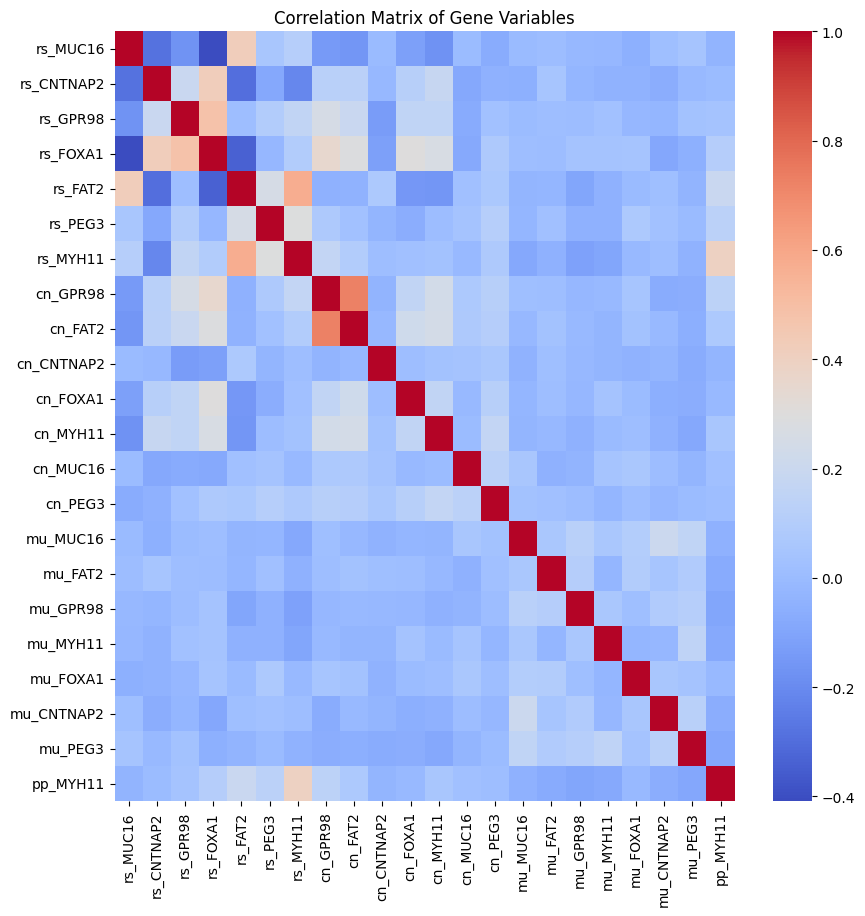

In [11]:
corr_matrix = df_unique_genes.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix of Gene Variables")
plt.show()